<h1>Grid Search</h1>

In [8]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from catboost import CatBoostRegressor, Pool
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

<h3>A - Prepare for Grid Search</h3>

In [2]:
features_names = [
    'flight_id',
    'month-day',
    'month',
    'day_in_month',
    'adep', 
    'country_code_adep', 
    'ades', 
    'country_code_ades', 
    'aircraft_type', 
    'wtc', 
    'airline', 
    'flight_duration', 
    'taxiout_time', 
    'flown_distance', 
    'actual_offblock_time_hour', 
    'actual_offblock_time_minute', 
    'actual_offblock_time_hour_minute', 
    'arrival_time_hour', 
    'arrival_time_minute', 
    'arrival_time_hour_minute', 
    'latitude_median', 
    'longitude_median', 
    'altitude_mean', 
    'groundspeed_mean', 
    'track_mean', 
    'vertical_rate_mean', 
    'track_unwrapped_mean', 
    'u_component_of_wind_mean', 
    'v_component_of_wind_mean', 
    'temperature_mean', 
    'specific_humidity_mean'
]

target = 'tow'

In [3]:
encoded_challenge_set = pd.read_csv('../../data/encoded_challenge_set.csv')

# Pick up features from dataset
features = encoded_challenge_set[features_names]

# Pick up target from dataset
target = encoded_challenge_set[target]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=True)

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=123)

# Function to print the best parameters and best RMSE score after tunning
def print_model_score(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("\nBest Score (Root Mean Squared Error):", grid_search.best_score_)

<h3>B - Perform Grid Search</h3>

In [5]:
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength': [0.0, 1.0, 2.0]
}

model = CatBoostRegressor(
    verbose=0, 
    random_seed=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv_strategy,
    n_jobs=-1,  # Use all available cores
    verbose=2
)  # Print detailed progress

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print Grid Search Results
print_model_score(grid_search)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'bagging_temperature': 0.5, 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'random_strength': 1.0}

Best Score (Root Mean Squared Error): -5003.103618868649


<h3>C - Evaluate Best Estimator</h3>

In [6]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = rmse(y_test, y_pred)
print("Test RMSE: ", test_rmse)

Test RMSE:  4990.571415314757


<h3>D - Feature Importances</h3>

In [11]:
# Get feature importance
feature_importances = best_model.get_feature_importance(Pool(X_train, y_train), type='PredictionValuesChange')

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print(importance_df)

                             Feature  Importance
9                                wtc   69.722138
8                      aircraft_type   15.812842
13                    flown_distance    3.952259
10                           airline    2.963756
11                   flight_duration    2.647599
4                               adep    1.762153
6                               ades    1.246742
5                  country_code_adep    0.467928
23                  groundspeed_mean    0.426923
20                   latitude_median    0.322495
7                  country_code_ades    0.270111
22                     altitude_mean    0.143276
21                  longitude_median    0.111777
0                          flight_id    0.048196
1                          month-day    0.044994
12                      taxiout_time    0.014807
16  actual_offblock_time_hour_minute    0.009658
19          arrival_time_hour_minute    0.008404
2                              month    0.007550
30            specif

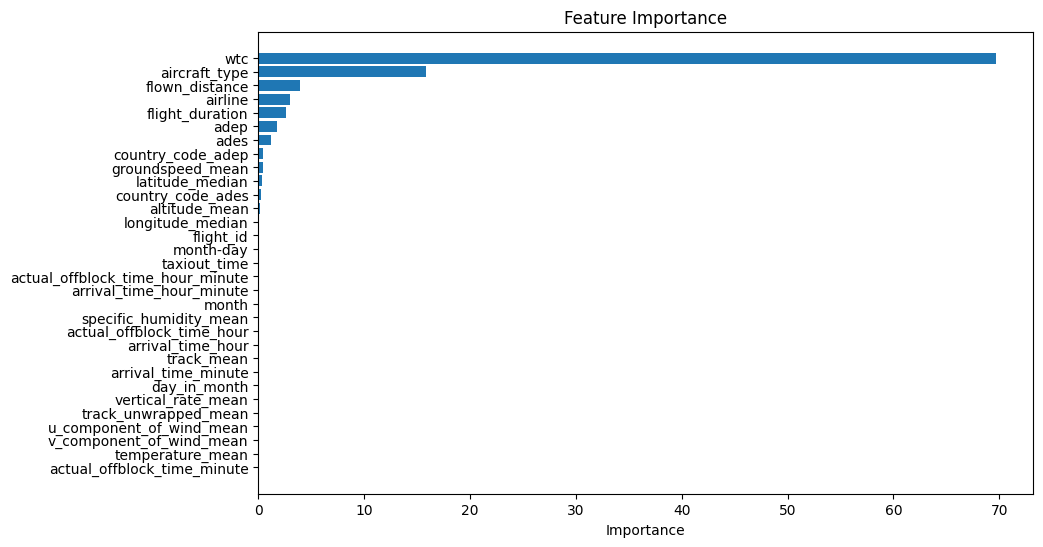

In [12]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()